In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [8]:
DATA_BUILD = False

In [199]:
classes = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
classes_counts = {'buildings': 0, 'forest': 0, 'glacier': 0, 'mountain': 0, 'sea': 0, 'street': 0}

TRAIN_PATH = "data/seg_train"
TEST_PATH = "data/seg_test"
PRED_PATH = "data/seg_pred"
IMG_SIZE = 50
training_data = []
testing_data = []
pred_data = []

In [200]:
def make_data(PATH):
    if not DATA_BUILD:
        if PATH == "data/seg_pred":
            print('Making Prediction Data')
            for file in tqdm(os.listdir(PATH)):
                try:
                    image_path = os.path.join(PRED_PATH, file)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    pred_data.append([np.array(img), file])
                except:
                    pass
                
        else:
            if PATH == "data/seg_train":
                print('Making Training Data')
            elif PATH == "data/seg_test":
                print('Making Test Data')
            for each_class in classes:
                for file in tqdm(os.listdir(os.path.join(PATH, each_class))):
                    try:
                        image_path = os.path.join(PATH, each_class, file)
                        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        if PATH == "data/seg_train":
                            training_data.append([np.array(img), np.eye(6)[classes[each_class]]])
                            classes_counts[each_class] += 1
                        elif PATH == "data/seg_test":
                            testing_data.append([np.array(img), np.eye(6)[classes[each_class]]])
                    except Exception as e:
                        pass
                                       
make_data(TRAIN_PATH)
make_data(TEST_PATH)
make_data(PRED_PATH)

  3%|█▎                                             | 203/7301 [00:00<00:03, 1820.27it/s]

Making Prediction Data


100%|██████████████████████████████████████████████| 7301/7301 [00:03<00:00, 1957.32it/s]


In [201]:
np.random.shuffle(training_data)
np.random.shuffle(pred_data)
np.random.shuffle(testing_data)

np.save('data/np_data/training_data.npy', training_data)
np.save('data/np_data/testing_data.npy', testing_data)
np.save('data/np_data/pred_data.npy', pred_data)

In [193]:
classes_counts

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

In [2]:
training_data = np.load("data/np_data/training_data.npy", allow_pickle=True)
testing_data = np.load("data/np_data/testing_data.npy", allow_pickle=True)
pred_data = np.load("data/np_data/pred_data.npy", allow_pickle=True)

In [3]:
training_data.shape

(0,)

In [77]:
testing_data.shape

(3000, 2)

In [203]:
pred_data.shape

(7301, 2)

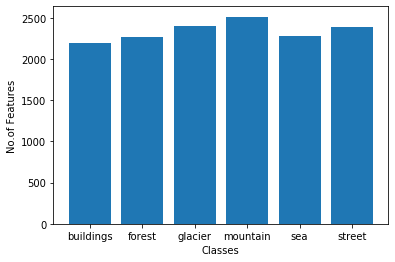

In [88]:
def view_balance(data):
#     fig = plt.figure(figsize=(8, 8))
    plt.bar(range(len(list(data.keys()))), list(data.values()))
    plt.xticks(range(len(data.keys())), list(data.keys()))
    plt.xlabel('Classes')
    plt.ylabel('No.of Features')
    plt.show()
    
view_balance(classes_counts)

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [122]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # we initialize our conv layers
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # now we need to find out the size of the next input layers
        # for that we initialize random data for the input size so that we can findout the input shape of the
        # flatten layer
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 6)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [123]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)


In [124]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [105]:
train_X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
train_X = train_X / 255.0
train_y = torch.Tensor([i[1] for i in training_data])

test_X = torch.Tensor([i[0] for i in testing_data]).view(-1, 50, 50)
test_X = test_X / 255.0
test_y = torch.Tensor([i[1] for i in testing_data])

In [117]:
epoch_loss = []
epoch_accuracy = []

In [143]:
BATCH_SIZE = 100
EPOCHS = 5

In [172]:
for epoch in range(EPOCHS):
    print('EPOCH', epoch + 1)
    val_off = int(0.1 * len(train_X))
    batch_X = train_X[:-val_off]
    batch_y = train_y[:-val_off]
    
    batch_val_X = train_X[-val_off:]
    batch_val_y = train_y[-val_off:]
    for i in tqdm(range(0, len(batch_X), BATCH_SIZE)):
        batch_train_X = batch_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_train_y = batch_y[i:i + BATCH_SIZE]
        
        net.zero_grad()
        
        output = net(batch_train_X)
        loss = loss_function(output, batch_train_y)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        val_loss = loss_function(net(batch_val_X.view(-1, 1, 50, 50)), batch_val_y)
    
    epoch_loss.append([loss.item(), val_loss.item()])  
    print('Epoch Loss: ', 'Training Loss', loss, ', Validation Loss', val_loss)
       

  0%|                                                            | 0/127 [00:00<?, ?it/s]

EPOCH 1


  0%|                                                            | 0/127 [00:00<?, ?it/s]

Epoch Loss:  Training Loss tensor(0.0544, grad_fn=<MseLossBackward>) , Validation Loss tensor(0.0765)
EPOCH 2


  0%|                                                            | 0/127 [00:00<?, ?it/s]

Epoch Loss:  Training Loss tensor(0.0603, grad_fn=<MseLossBackward>) , Validation Loss tensor(0.0709)
EPOCH 3


  0%|                                                            | 0/127 [00:00<?, ?it/s]

Epoch Loss:  Training Loss tensor(0.0531, grad_fn=<MseLossBackward>) , Validation Loss tensor(0.0732)
EPOCH 4


  0%|                                                            | 0/127 [00:00<?, ?it/s]

Epoch Loss:  Training Loss tensor(0.0566, grad_fn=<MseLossBackward>) , Validation Loss tensor(0.0727)
EPOCH 5


100%|██████████████████████████████████████████████████| 127/127 [01:01<00:00,  2.06it/s]


Epoch Loss:  Training Loss tensor(0.0392, grad_fn=<MseLossBackward>) , Validation Loss tensor(0.0709)


In [173]:
with torch.no_grad():
    output = net(test_X.view(-1, 1, 50, 50))
    correct = 0
    total = 0
    for i, dat in enumerate(test_y):
        predicted = torch.argmax(output[i])
        real_class = torch.argmax(dat)
        
        if real_class == predicted:
            correct += 1
        total += 1
    
    print('Testing accuracy', round(correct/total, 4) * 100.0)

Testing accuracy 70.19999999999999


In [176]:
# For some reason our epoch loss array is totally messed up, but the last 5 entries correspond to correct values, hence

In [177]:
epoch_loss = epoch_loss[-5:]

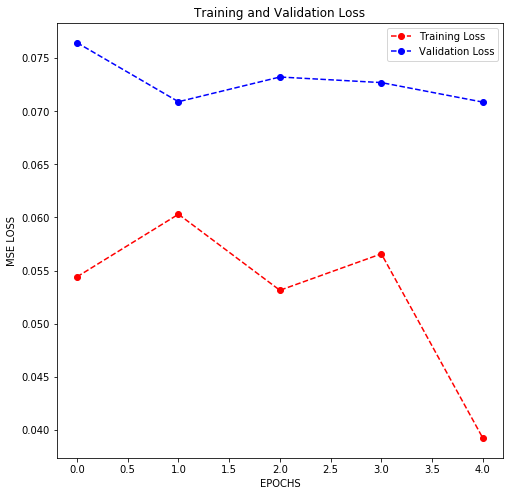

In [181]:
def plot_epoch_loss(data):
    plt.figure(figsize=(8, 8))
    data = np.array(data)
    plt.plot(data[:, 0], 'ro--', label='Training Loss')
    plt.plot(data[:, 1], 'bo--', label='Validation Loss')
    plt.legend()
    plt.xlabel('EPOCHS')
    plt.ylabel('MSE LOSS')
    plt.title('Training and Validation Loss')
    plt.show()

plot_epoch_loss(epoch_loss)

In [188]:
# Now using the model we made we can use to predict the labels for the pred_data, before that let's save the model

import pickle
pickle.dump(net, open("model/model.pickle", "wb"))

# or using torch to save model
torch.save(net, open("model/trained_model.pickle", "wb"))

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [221]:
prediction_class = {}

for data, name in pred_data:
    data = torch.Tensor(data).view(-1, 1, 50, 50)
    prediction = list(classes.keys())[torch.argmax(net(data)).item()]
    prediction_class[name] = prediction

prediction_class

{'11172.jpg': 'glacier',
 '4180.jpg': 'glacier',
 '12376.jpg': 'mountain',
 '11163.jpg': 'mountain',
 '2844.jpg': 'street',
 '17582.jpg': 'glacier',
 '3177.jpg': 'glacier',
 '3897.jpg': 'glacier',
 '9775.jpg': 'glacier',
 '4896.jpg': 'mountain',
 '17542.jpg': 'glacier',
 '20284.jpg': 'glacier',
 '10920.jpg': 'street',
 '14672.jpg': 'glacier',
 '17108.jpg': 'glacier',
 '10208.jpg': 'buildings',
 '20340.jpg': 'street',
 '7515.jpg': 'glacier',
 '14348.jpg': 'street',
 '6980.jpg': 'glacier',
 '15006.jpg': 'glacier',
 '12099.jpg': 'glacier',
 '8776.jpg': 'street',
 '13302.jpg': 'glacier',
 '653.jpg': 'street',
 '21566.jpg': 'glacier',
 '7504.jpg': 'glacier',
 '7844.jpg': 'glacier',
 '6296.jpg': 'glacier',
 '10875.jpg': 'glacier',
 '19099.jpg': 'glacier',
 '4993.jpg': 'street',
 '6862.jpg': 'glacier',
 '17436.jpg': 'glacier',
 '11769.jpg': 'glacier',
 '8106.jpg': 'street',
 '17163.jpg': 'glacier',
 '11071.jpg': 'glacier',
 '15902.jpg': 'glacier',
 '23730.jpg': 'glacier',
 '9397.jpg': 'buildi

In [228]:
# let's try copying the images to repective folders and check
import shutil
source = "./data/predictions"
for file in prediction_class:
    dest = source + f"/{prediction_class[file]}"
    source_ = source + f"/{file}"
    shutil.move(source_, dest)

print('All predictions have to moved to their respective folders, please check them at "predictions" folder under data')

All predictions have to moved to their respective folders, please check them at "predictions" folder under data
